# Lab 02 - Wprowadzenie do AI

Celem tego notebook'a jest przejście przez podstawowe zagadnienia związane z uczeniem maszynowym. Wszystko można wykonać u siebie lokalnie instalując biblioteki z pliku `requirements.txt`, natomiast można wszystko również wykonać przy wykorzystaniu Google Colab

[![Otwórz w Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aghbit/BIT-AI-Intro/blob/main/lab_02/main.ipynb)

In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.4 MB/s eta 0:00:00


In [5]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random.seed(2)
np.random.seed(2)

---
## Szukanie optymalnego rozwiązania funkcji

Zanim przejdziemy do tematyki związanej z uczeniem maszynowym, zajmiemy się zagadnieniem optymalizacji funkcji. Dzisiaj zajmiemy się funkcją

$$f(x) = (x + 0.1)^2-\frac{7x}{10}\sin(20 * x) + 1$$

Oczywiście jeżeli poświęcimy wystarczająco dużo czasu, to możemy rozwiązać to zadanie analitycznie, natomiast to nie jest celem tego ćwiczenia.

Na początku zwizualizujemy funkcję, aby zobaczyć jak wygląda. W tym celu wykorzystamy bibliotekę `matplotlib` oraz `numpy`.

Attemps:  [0 1]


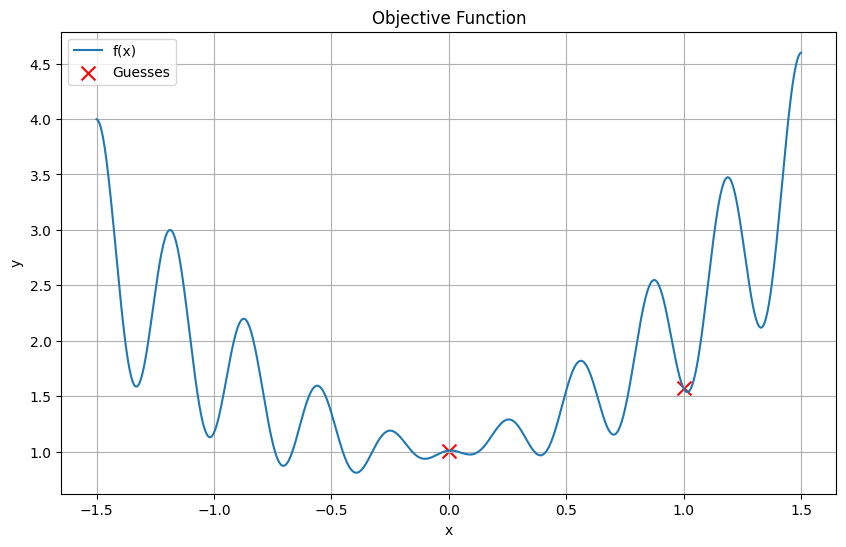

In [6]:
def func(x):
    return (x + 0.1) ** 2 - 7 * x * np.sin(20 * x) / 10 + 1

def create_plot(guesses=None):
    x = np.linspace(-1.5, 1.5, 1000)
    y = func(x)
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="f(x)")

    if guesses is not None:
        print("Attemps: ", guesses)
        y0 = func(guesses)
        plt.scatter(guesses, y0, color='red', label="Guesses", s=100, marker='x')

    plt.title("Objective Function")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid()
    plt.show()

create_plot(np.array([0, 1]))


---
### Random Search

Najprostszą metodą na znalezienie dobrego rozwiązania jest przeszukanie losowe naszej dziedziny. Random Search polega na losowaniu punktów i sprawdzaniu ich wartości. Oczywiście zazwyczaj obliczenie wartości funkcji jest kosztowne, więc nie możemy sobie pozwolić na zbyt wiele prób. Tutaj, ograniczymy się do 10 prób.

**Zadanie 1.**
Zaimplementować funkcję `suggest_random_x`, która będzie losować punkty w zakresie $[a, b]$

In [ ]:
def suggest_random_x(a, b):
    raise NotImplementedError("This function should be implemented by the user.")

guesses = np.array([suggest_random_x(-1.5, 1.5) for _ in range(10)])
create_plot(guesses)

In [ ]:
print("Top Scores: ", min(func(guesses)))

---
### Optuna

Może i wynik nie jest najgorszy, natomiast nie jest to najlepsza metoda. Często okazuje się, że informację o wartościach funkcji w innych miejscach możemy wykorzystać w następnym zgadywaniu. Jedną z bibliotek, która to robi jest `Optuna`. Aby z niej skorzystać, musimy zdefiniować funkcję celu, która będzie zgadywała wartości funkcji i zwracała jej wartość. Przykładowa funkcja celu wygląda tak:

```python
def objective(trial):
    x = trial.suggest_int("x", 0, 10)
    return (x - 4) ** 2
```

W powyższym przykładzie, `trial` to obiekt, który przechowuje informacje o próbie. `suggest_int` to metoda, która losuje wartość zmiennej `x` z przedziału [0, 10]. Następnie zwracamy wartość funkcji celu. Wartością zwracaną przez funkcję celu jest wartość funkcji, którą chcemy zminimalizować. Przykład wykorzystania znajdziecie w tym [tutorialu](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/003_attributes.html).

**Zadanie 2.**
Zaimplementować funckję celu wykorzystując bibliotekę `Optuna`.

In [ ]:
def objective(trial):
    raise NotImplementedError("This function should be implemented by the user.")

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print("Best Score: ", study.best_value)
print("Best Params: ", study.best_params)
all_guesses = [trial.params["x"] for trial in study.trials]
create_plot(np.array(all_guesses))

**Zadanie 3.**
Poniżej znajduje się funkcja Rastrigin, która jest funkcją testową. Wykorzystać `Random Search` oraz `Optuna` do znalezienia minimum tej funkcji. Funkcja Rastrigin jest zdefiniowana jako:
$$f(x) = An + \sum_{i=1}^{n} [x_i^2 - A \cos(2 \pi x_i)]$$

Która poradziła sobie lepiej? Porównaj wyniki dla 2, 5 i 100 wymiarów.

In [19]:
def rastrigin(x, A=10):
    return A * len(x) + sum([(xi ** 2 - A * np.cos(2 * np.pi * xi)) for xi in x])

def random_search_rastrigin(dim, n_trials=1000, a=-5.12, b=5.12):
    best_x = None
    best_val = float('inf')
    for _ in range(n_trials):
        x = [random.uniform(a, b) for _ in range(dim)]
        val = rastrigin(x)
        if val < best_val:
            best_val = val
            best_x = x
    return best_x, best_val

def optuna_rastrigin(dim, n_trials=100):
    def objective(trial):
      x = [trial.suggest_float(f"x{i}", -5.12, 5.12) for i in range(dim)]
      return rastrigin(x)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study.best_value

dims = [2, 5, 100]
n_trials = 1000  # dla Random Search
n_trials_optuna = 100  # dla Optuna

for dim in dims:
    rs_x, rs_val = random_search_rastrigin(dim, n_trials)
    opt_params, opt_val = optuna_rastrigin(dim, n_trials_optuna)

    print(f"Dimension: {dim}")
    print(f"Random Search: best value = {rs_val:.4f}")
    print(f"Optuna: best value = {opt_val:.4f}")
    print("-"*30)



[I 2025-09-20 11:52:54,127] A new study created in memory with name: no-name-d843f56e-35e7-4b55-a525-09283f7365a7
[I 2025-09-20 11:52:54,130] Trial 0 finished with value: 34.31926416474196 and parameters: {'x0': 5.02320315419779, 'x1': 2.9733646248147165}. Best is trial 0 with value: 34.31926416474196.
[I 2025-09-20 11:52:54,132] Trial 1 finished with value: 41.27381718159947 and parameters: {'x0': -2.354609293315923, 'x1': -2.71379435329745}. Best is trial 0 with value: 34.31926416474196.
[I 2025-09-20 11:52:54,134] Trial 2 finished with value: 28.596724870039665 and parameters: {'x0': -4.071590446649395, 'x1': -0.26520353701280897}. Best is trial 2 with value: 28.596724870039665.
[I 2025-09-20 11:52:54,136] Trial 3 finished with value: 34.30806399822761 and parameters: {'x0': 1.241504162759143, 'x1': -3.2898411792820665}. Best is trial 2 with value: 28.596724870039665.
[I 2025-09-20 11:52:54,139] Trial 4 finished with value: 44.41734788734127 and parameters: {'x0': 1.5225552315741036

Dimension: 2
Random Search: best value = 2.1363
Optuna: best value = 4.1801
------------------------------


[I 2025-09-20 11:52:55,055] Trial 23 finished with value: 61.98422211387937 and parameters: {'x0': 0.6904890722253325, 'x1': 2.374147420795491, 'x2': -0.732556704996786, 'x3': -2.155145052801979, 'x4': -2.042359333214197}. Best is trial 15 with value: 44.85568261045724.
[I 2025-09-20 11:52:55,069] Trial 24 finished with value: 78.81310937394416 and parameters: {'x0': -1.5268742682236818, 'x1': 0.9488757890434354, 'x2': 1.481466387647082, 'x3': -0.30059161997153083, 'x4': 0.4583287842140029}. Best is trial 15 with value: 44.85568261045724.
[I 2025-09-20 11:52:55,081] Trial 25 finished with value: 57.32124317376524 and parameters: {'x0': -0.03063086209209165, 'x1': -0.3387493101333871, 'x2': 3.379192405292457, 'x3': 0.7756174841814416, 'x4': -0.8667415140986368}. Best is trial 15 with value: 44.85568261045724.
[I 2025-09-20 11:52:55,094] Trial 26 finished with value: 53.385405868952716 and parameters: {'x0': 1.9396229986191735, 'x1': 3.9552992785166388, 'x2': -3.0407995570336697, 'x3': 3

Dimension: 5
Random Search: best value = 25.2573
Optuna: best value = 28.0374
------------------------------


[I 2025-09-20 11:52:56,402] Trial 2 finished with value: 2031.3715097859028 and parameters: {'x0': -4.711924667165656, 'x1': 4.749161902360334, 'x2': 1.5381231916475455, 'x3': -0.5109887330282916, 'x4': 5.105481554592491, 'x5': -3.1732449252547177, 'x6': 1.7211474137676745, 'x7': 2.9337641447253064, 'x8': 4.213338365767091, 'x9': 1.384341837313432, 'x10': -2.792417914033222, 'x11': 2.0697731796249865, 'x12': -3.3296481627769823, 'x13': -4.676451983828017, 'x14': -1.5402497004250768, 'x15': 0.3619961759312984, 'x16': -5.063750600213978, 'x17': 4.545197201194953, 'x18': 1.4140220386098683, 'x19': -0.7284739083780387, 'x20': -2.525174685425201, 'x21': -4.423227034012569, 'x22': 3.782085447414368, 'x23': -3.790602815129237, 'x24': 3.1076629701393026, 'x25': 1.9364438143260978, 'x26': -1.952805533402528, 'x27': 1.28810112330593, 'x28': 2.5343974728829357, 'x29': -0.361707095192088, 'x30': 1.2794716672872184, 'x31': -2.3079794666953535, 'x32': 4.573341402339584, 'x33': -3.272377584457021, 'x

Dimension: 100
Random Search: best value = 1560.9026
Optuna: best value = 1418.5738
------------------------------


---
## Hiperparametry

Modele uczenia maszynowego często mają hiperparametry. Modele przy poprawnie zaimplementowanej metodzie uczenia, dla stałych danych, za każdym razem zwrócą ten sam wynik. Natomiast zmieniając hiperparametry, możemy uzyskać różne wyniki.

Naszym celem będzie teraz wykorzystanie wiedzy nabytej wcześniej, aby poprawić wynik modelu.

Tym razem będziemy musieli napisać trochę kodu sami (natomiast możecie wracać do kodu z wcześniejszych zajęć, który uzupełniliście sami w wolnym czasie, zrobiliście to, prawda?). Wracamy do danych z ostatniego labu, czyli do danych o `titanicu`. Ładujemy plik `data/titanic.csv` za pomocą bilioteki `pandas`. Dokumentacja:

### pandas
- [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
- [mean](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html)
- [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

### scikit-learn
- [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

**Zadanie 4.**
1. Załaduj dane
2. Zostaw kolumny: `Survived`, `Pclass`, `Age`, `SibSp`, `Parch`, `Fare`
3. Uzupełnij braki średnimi wartościami
4. Podziel dane na zbiór treningowy i testowy (70% - 30%)

In [12]:
orig_titanic = pd.read_csv('/content/titanic.csv')
dropped_titanic = orig_titanic.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked', 'PassengerId', 'Sex'])
means = dropped_titanic.mean()
clean_titanic = dropped_titanic.fillna(means)

train, test = train_test_split(clean_titanic, train_size=0.7, random_state=70)

train_X = train.drop(columns=['Survived'])
train_y = train['Survived']

test_X = test.drop(columns=['Survived'])
test_y = test['Survived']

Następnie wykorzystamy model `RandomForestClassifier` z biblioteki `scikit-learn`, do uzyskania początkowego modelu. Przetestujemy jego dokładność na zbiorze testowym, co będzie naszym punktem wyjścia.

**Zadanie 5.**
1. Załaduj model `RandomForestClassifier` z biblioteki `scikit-learn` (ustaw random_state na 42)
2. Wytrenuj model na zbiorze treningowym
3. Sprawdź dokładność modelu na zbiorze testowym przy wykorzystaniu metryki `accuracy`

In [13]:
model = RandomForestClassifier()
model.fit(train_X, train_y)

pred = model.predict(test_X)
acc = accuracy_score(test_y, pred)
print(f"accuracy: {acc*100:.2f}%")

accuracy: 61.90%


Teraz możemy przejśc do optymalizacji hiperparametrów. Dokumentację tej klasy możemy znaleźć [tutaj](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

**Zadanie 6.**
Wykorzystaj bibliotekę `Optuna` do optymalizacji hiperparametrów modelu `RandomForestClassifier`.

In [16]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=70
    )
    model.fit(train_X, train_y)

    pred = model.predict(test_X)
    acc = accuracy_score(test_y, pred)

    return 1.0 - acc


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print("best score: ", study.best_value)
print("best params: ", study.best_params)


best_model = RandomForestClassifier(**study.best_params, random_state=70)
best_model.fit(train_X, train_y)
pred = best_model.predict(test_X)
acc = accuracy_score(test_y, pred)
print(f"test accuracy: {acc*100:.2f}%")

[I 2025-09-20 11:36:39,901] A new study created in memory with name: no-name-eddffd0e-1560-4ff3-a573-00bb466cf0c7
[I 2025-09-20 11:36:40,057] Trial 0 finished with value: 0.3571428571428571 and parameters: {'n_estimators': 85, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.3571428571428571.
[I 2025-09-20 11:36:40,731] Trial 1 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 367, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.3571428571428571.
[I 2025-09-20 11:36:41,064] Trial 2 finished with value: 0.3492063492063492 and parameters: {'n_estimators': 179, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 2 with value: 0.3492063492063492.
[I 2025-09-20 11:36:41,674] Trial 3 finished with value: 0.4126984126984127 and parameters: {'n_estimators': 385, 'max_depth': 2, 'min_

best score:  0.3492063492063492
best params:  {'n_estimators': 179, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None}
test accuracy: 65.08%


---
## Bayes error rate

Istnieje twierdzenie, które mówi nam o najniższym możliwym błędzie klasyfikacji, który możemy uzyskać. Jest to tzw. Bayes error rate ([link dla zainteresowanych](https://en.wikipedia.org/wiki/Bayes_error_rate])). W dużym skrócie, czasami lepiej się nie da i trenowanie modelu nie pomoże.

W uproszczeniu. Mamy samochody marki `X`. Każdy samochód marki `X` ma wagę i moc silnika (i to są jedyne parametry tego samochodu, załóżmy że reszta znajduje się w stanie kwantowym i nic o nich nie wiemy), a my chcemy stworzyć model, który na podstawie wagi, będzie zwracał moc silnika. Co więcej, wiemy, że moc silnika jest opisana jako:

$$\frac{\texttt{waga}}{10}\pm20$$

matematycznie zapiszemy to jako:
$$\texttt{moc} = \frac{\texttt{waga}}{10} + U(-20, 20)$$

Czyli auto, które waży 2 tony, będzie miało moc pomiędzy 180 a 220 KM. W takim przypadku, nawet jeżeli stworzymy najlepszy model na świecie, to i tak nie będziemy w stanie przewidzieć mocy silnika z wagą.

Zależnie od metryki, którą zastosujemy, możemy dostać trochę inne modele, które będą optymalne dla tak opisanych samochodów marki `X`.

Jeżeli zastosujemy metryki `MSE`, `MAE`, `RMSE`, to optymalny model będzie opisany jako:
$$\frac{\texttt{waga}}{10}$$

Jeżeli zastosujemy metrykę `Coverage(k)`, to optymalnymi modelami będą wszystkie modele opisane jako:
$$\frac{\texttt{waga}}{10} + b$$
gdzie $b$ to dowolna liczba z przedziału $[-(20-k), 20-k]$.
